In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io
import sys

sys.path.append("../")
sys.path.append("../..")
from util import *
from model.pinn import PINNs

# 无粘Burgers方程: u_t + u*u_x = 0
# IC:u(x, 0) = sin
# BC:u(0, t) = u(2π, t)

# 构造一个burgers数据

Iteration 799: x = 3.179943524638314, loss = 2.186836186561628
5.340707511102649 0.68
Iteration 799: x = 5.012029364123284e+27, loss = 5.012029364123284e+27
4.1469023027385274 1.0
Iteration 799: x = 2.72730492556962e+37, loss = 2.72730492556962e+37
6.220353454107791 1.0


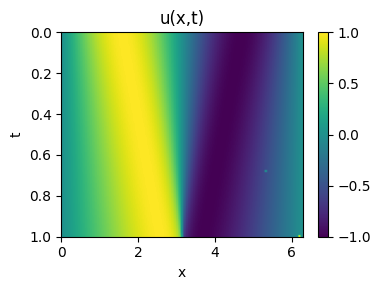

In [7]:
# 生成burgers数据集，真解：
# u(x, t) = sin(x_0)
# x = x_0 + sin(x_0) * t

# 定义隐式方程和其导数
def f(x, a, b):
    return x + np.sin(x) * b - a

def df(x, b):
    return 1 + b * np.cos(x)

# Newton-Raphson方法求解x0
def newton_method(a, b, x0, tol=1e-3, max_iter=1000):
    x = x0
    for i in range(max_iter):
        # 更新x
        x_new = x - f(x, a, b) / df(x, b)
        x = x_new
        # 每10次迭代打印一次信息
        if (i+1) % 800 == 0:
            print(f"Iteration {i}: x = {x_new}, loss = {np.abs(f(x_new, a, b)).max()}")
            print(a, b)

        # 判断是否收敛
        if np.abs(f(x, a, b)) < tol:
            return x
    return x  # 返回最终迭代结果

# 定义函数求解 Burgers 方程的解析解
def get_burgers(x, t):

    xi = np.zeros(x.shape)
    for i in range(x.shape[0]):
        xi[i] = newton_method(x[i], t[i], 1)

    return np.sin(xi)

# 获取测试数据
test, _, _, _, _ = get_data([0, 2*np.pi], [0, 1], 101, 101)  # (10201, 2)

x = test[:, 0]  # (10201, 1)
t = test[:, 1]

# 计算解析解
u = get_burgers(x, t).reshape(101, 101)


plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

# 定义保存的字典，键名为 'u'
data_dict = {'u': u}

# 使用 scipy.io.savemat 保存为 .mat 文件
scipy.io.savemat('burgers.mat', data_dict)

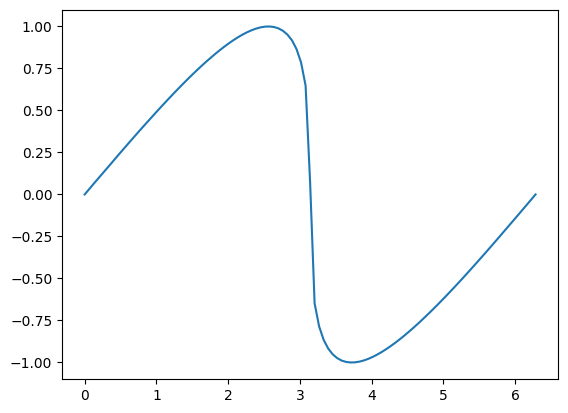

In [8]:
u_1 = u[99, :]
x = np.linspace(0, 2*np.pi, 101)
plt.plot(x, u_1)
plt.show()

# PDEBench中的数据

<KeysViewHDF5 ['t-coordinate', 'tensor', 'x-coordinate']>
(202,) (1024,) (201, 1024)


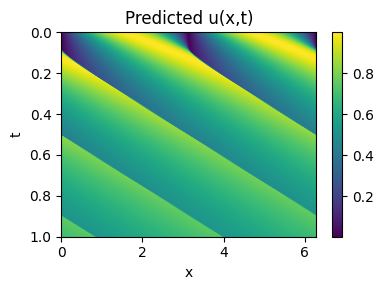

In [9]:
import h5py

path = '/home/data2/PDEData/1D/Burgers/Test/Burgers_possin_u1.0_Nu0.001.hdf5'
with h5py.File(path, 'r') as f:
    print(f.keys())
    t = f['t-coordinate'][:]
    x = f['x-coordinate'][:]
    u = f['tensor'][:]

print(t.shape, x.shape, u.shape)
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/burgers_PDEBench.png')
plt.show()

# 构造burgers

无粘Burgers方程: u_t + u*u_x = 0, [-1, 1]*[0, 0.5]

IC:u(x, 0) = 1, x<=0; u(x, 0) = -1, x>0

BC:u(0, t) = u(2π, t)

[-1.   -0.98 -0.96 ...  0.96  0.98  1.  ]
[0.  0.  0.  ... 0.6 0.6 0.6]


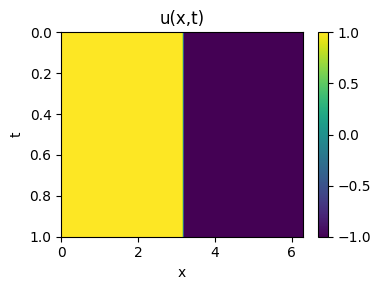

In [3]:
def get_burgers(x, t):
    # 真解：u(x, t) = 1, x<=0; u(x, t) = -1, x>0
    u = np.where(x <= 0, 1, -1)
    return u

# 获取测试数据
test, _, _, _, _ = get_data([-1, 1], [0, 0.6], 101, 101)  # (10201, 2)

x = test[:, 0]  # (10201, 1)
t = test[:, 1]
print(x)
print(t)

# 计算解析解
u = get_burgers(x, t).reshape(101, 101)

plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

# 定义保存的字典，键名为 'u'
data_dict = {'u': u}

# 使用 scipy.io.savemat 保存为 .mat 文件
scipy.io.savemat('burgers.mat', data_dict)

In [31]:
def get_data(x_range, y_range, x_num, y_num):
    # 在[0,X]*[0,T]区域采样
    x = np.linspace(x_range[0], x_range[1], x_num)  # [x_range0, x_range1]
    t = np.linspace(y_range[0], y_range[1], y_num)  # [y_range0, y_range1]

    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_init = data[0,:,:]  # 初始时刻
    b_end = data[-1,:,:]
    b_left = data[:,0,:]
    b_right = data[:,-1,:]
    res = data.reshape(-1,2)

    return res, b_init, b_end, b_left, b_right

# 获取测试数据
test, _, _, _, _ = get_data([-1, 1], [0, 0.6], 101, 101)  # (10201, 2)
print(test.reshape(101, 101, 2))


[[[-1.     0.   ]
  [-0.98   0.   ]
  [-0.96   0.   ]
  ...
  [ 0.96   0.   ]
  [ 0.98   0.   ]
  [ 1.     0.   ]]

 [[-1.     0.006]
  [-0.98   0.006]
  [-0.96   0.006]
  ...
  [ 0.96   0.006]
  [ 0.98   0.006]
  [ 1.     0.006]]

 [[-1.     0.012]
  [-0.98   0.012]
  [-0.96   0.012]
  ...
  [ 0.96   0.012]
  [ 0.98   0.012]
  [ 1.     0.012]]

 ...

 [[-1.     0.588]
  [-0.98   0.588]
  [-0.96   0.588]
  ...
  [ 0.96   0.588]
  [ 0.98   0.588]
  [ 1.     0.588]]

 [[-1.     0.594]
  [-0.98   0.594]
  [-0.96   0.594]
  ...
  [ 0.96   0.594]
  [ 0.98   0.594]
  [ 1.     0.594]]

 [[-1.     0.6  ]
  [-0.98   0.6  ]
  [-0.96   0.6  ]
  ...
  [ 0.96   0.6  ]
  [ 0.98   0.6  ]
  [ 1.     0.6  ]]]


(10201,) (10201,)
[-1.   -0.98 -0.96 ...  0.96  0.98  1.  ]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


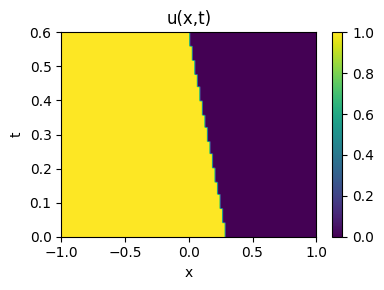

In [7]:
# 初始条件：u(x, 0) =1, x ≤ 0; u(x, 0) =0, x > 0
# 真解： u(x, t) =1, x ≤ t/2; u(x, 0) =0, x > t/2

def get_burgers(x, t):
    # 真解： u(x, t) =1, x ≤ t/2; u(x, 0) =0, x > t/2
    # x [10201]
    # t [10201]
    u = np.where(x <= t/2, 1, 0)
    return u.reshape(101, 101)

# 获取测试数据
test, _, _, _, _ = get_data([-1, 1], [0, 0.6], 101, 101)  # (10201, 2)

x = test[:, 0]  # (10201, 1)
t = test[:, 1]
print(x.shape, t.shape)
print(x)
# print(t)

# 计算解析解
u = get_burgers(x, t)
u = u
print(u)

plt.figure(figsize=(4,3))
plt.imshow(u, extent=[-1,1,0,0.6], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

# 定义保存的字典，键名为 'u'
data_dict = {'u': u}

# 使用 scipy.io.savemat 保存为 .mat 文件
# scipy.io.savemat('burgers_move.mat', data_dict)